# `AML — Task 2:` Heart rhythm classification from raw ECG signals
---

In [ ]:
# For TQDM :
#! python3.6 -m pip install ipywidgets
#! python3.6 -m pip install --upgrade jupyter
#! jupyter nbextension enable --py widgetsnbextension

In [1]:
import numpy as np
import pandas as pd
import biosppy.signals.ecg as ecg
import biosppy.signals.tools as tools
from biosppy.plotting import plot_ecg
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [39]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
from bokeh.palettes import Dark2_8

In [34]:
utils = __import__('features-utils')

---
## Dataset import and export to `csv`

In [3]:
def load_from_csv(extension="", drop_id = True):
    X_train = pd.read_csv('data/X_train' + extension + '.csv')
    y_train = pd.read_csv('data/y_train' + extension + '.csv')
    X_test  = pd.read_csv('data/X_test' + extension + '.csv')
    
    if drop_id:
        X_train = X_train.drop(columns=['id'])
        y_train = y_train.drop(columns=['id'])
        X_test  = X_test.drop(columns=['id'])
     
    return X_train, y_train, X_test

In [4]:
def export_to_csv(X_train, y_train, X_test, extension="_cleaned"):
    X_train.to_csv('data/X_train' + extension + '.csv', index=False)
    y_train.to_csv('data/y_train' + extension + '.csv', index=False)
    X_test.to_csv('data/X_test' + extension + '.csv', index=False)

## Submission export to `csv`

In [5]:
def create_submission(sub_id, pred, basepath='submissions/task2-sub'):
    result = pred.copy().rename(columns={0: 'y'})
    result['id'] = range(0, len(result))
    result = result[['id', 'y']]
    result.to_csv(basepath + str(sub_id) + '.csv', index=False)

---
## Visualization tool

In [92]:
def visualize(X_train: pd.DataFrame, y_train: np.array, feature1: str, feature2: str):
    df = X_train.copy()
    labels = y_train.copy().ravel()
    df['label'] = labels
    fm = utils.features_map()
    
    source = ColumnDataSource(
    data = {
        "x": [x for x in df[fm[feature1]]],
        "y": [x for x in df[fm[feature2]]],
        "name": [x for x in df['label']],
        "color": [Dark2_8[x] for x in df['label']],
    })

    hover = HoverTool(
        tooltips=[
            ("Name", "@name"),
        ])
    tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

    p = figure(plot_width=960, plot_height=360, tools=tools, x_axis_label=feature1, y_axis_label=feature2)
    p.circle("x", "y", source=source, size=10, color="color", alpha=0.5)
    show(p, notebook_handle=True);

---
## Data processing

In [6]:
def series_to_heartbeats(time_series: pd.Series, sampling_rate=300.0) -> np.array:
    no_nans = time_series.dropna()
    rpeaks = ecg.engzee_segmenter(no_nans, sampling_rate)['rpeaks']
    beats, rpeaks = ecg.extract_heartbeats(no_nans, rpeaks, sampling_rate)
    beats = beats if len(beats.shape) == 2 else beats.reshape((1, -1))
    return beats, rpeaks

### Feature extraction methods

In [7]:
def extract_qpeaks_features(filtered: np.array, rpeaks: np.array, window_size=50):
    qpeaks = [rpeak - window_size + np.argmin(filtered[rpeak-window_size:rpeak]) for rpeak in rpeaks]
    qpeaks_amplitudes = [filtered[qpeak] for qpeak in qpeaks]
    return qpeaks, qpeaks_amplitudes

In [8]:
def extract_speaks_features(filtered: np.array, rpeaks: np.array, window_size=50):
    speaks = [rpeak + np.argmin(filtered[rpeak:rpeak+window_size]) for rpeak in rpeaks]
    speaks_amplitudes = [filtered[speak] for speak in speaks]
    return speaks, speaks_amplitudes

### Main feature extraction method

In [9]:
def extract_stats_from(features_series: list) -> pd.Series:
    # pd.describe().drop(count) returns 7 interesting features (min, max, std...)
    fs = [pd.Series(s).describe().drop(["count"]) for s in features_series]
    return pd.concat(fs, ignore_index=True)

In [10]:
def extract_features(time_series: pd.Series, sampling_rate=300) -> pd.Series:
    # Drop nan values in the time series
    no_nans = time_series.dropna()
    
    # Extract main features from ECG
    ts, filtered, rpeaks, _, templates, _, heart_rate = ecg.ecg(no_nans, sampling_rate, show=False)
    assert len(rpeaks) > 1, 'ECG cannot have a single R peak'
    assert len(templates) > 1, 'ECG cannot have a single heartbeat'
    
    # Extract Q,R,S peak features
    rpeaks_amplitude = [filtered[rpeak] for rpeak in rpeaks]
    qpeaks, qpeaks_amplitude = extract_qpeaks_features(filtered, rpeaks)
    speaks, speaks_amplitude = extract_speaks_features(filtered, rpeaks)
    
    # Extract RR, QRS durations features
    rr_durations = [r2 - r1 for r1, r2 in zip(rpeaks, rpeaks[1:])]
    qrs_durations = [speak - qpeak for qpeak, speak in zip(qpeaks, speaks)]
    
    # Extract QRS direction features
    qrs_direction = [q + r + s for q, r, s in zip(qpeaks, rpeaks, speaks)]
    
    # Extract Q/R ratio features
    qr_ratio = [q / r for q, r in zip(qpeaks, rpeaks)]
    
    #TODO: Extract SNR ratio (http://www.cinc.org/archives/2011/pdf/0609.pdf)
    snr = np.quantile(np.std(templates, axis=0), 0.35)
    
    # Use this to go from index differences to seconds
    index_to_time = ts[-1] / len(filtered)
    # Extract pNN28 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1767394/)
    pNN28 = (np.array(rr_durations) * index_to_time > 0.028).sum() / len(rr_durations)
    
    ecg_features = extract_stats_from([
        rpeaks_amplitude, qpeaks_amplitude, speaks_amplitude,
        rr_durations, qrs_durations, qrs_direction, qr_ratio
    ])
    
    return ecg_features.append(pd.Series([snr, pNN28]), ignore_index=True)

---
## Data standardization

In [11]:
def standardize_data(X_train, X_test):
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return (X_train_scaled, X_test_scaled)

---
## Models defintions

In [12]:
def svc(X_train, y_train):
    svc = SVC()
    gs_svc_params = {
        "kernel": ["rbf", "poly", "sigmoid"],
        "C": np.logspace(0, 1, 2),
        "class_weight": ["balanced", None]
    }
    gs_svc = GridSearchCV(svc, gs_svc_params, cv=5, verbose=3, scoring='f1_micro', error_score='raise')
    gs_svc.fit(X_train, y_train)
    
    print(f"The best validation score obtained is {gs_svc.best_score_:.5f} +- \
        {gs_svc.cv_results_['std_test_score'][gs_svc.best_index_]:.5f} with\n\t{gs_svc.best_params_}")
    
    return gs_svc

In [13]:
def random_forest(X_train, y_train):
    random_forest = RandomForestClassifier()
    gs_forest_params = {
     "n_estimators": np.arange(100, 400, 100),
     "max_depth": [None], #np.arange(2, 8, 1),
     "min_samples_split": [2], #np.arange(2, 8, 1),
     "min_samples_leaf": [1], #np.arange(1, 9, 2),
     "class_weight": ["balanced", None],
     "random_state": [0], 
    }
    
    gs_forest = GridSearchCV(random_forest, gs_forest_params, cv=5, verbose=3, 
                             scoring='f1_micro', error_score='raise')
    
    gs_forest.fit(X_train, y_train)

    print(f"The best validation score obtained is {gs_forest.best_score_:.5f} +- \
        {gs_forest.cv_results_['std_test_score'][gs_forest.best_index_]:.5f} with\n\t{gs_forest.best_params_}")
    
    return gs_forest

In [14]:
def gbc(X_train, y_train):
    gbc = GradientBoostingClassifier()
    gs_gbc_params = {
        "loss": ["deviance"],
        "learning_rate": [0.1],
        "n_estimators": [100, 200],
        "subsample": [1],
        "criterion": ["friedman_mse", "mse"],
        "min_samples_split": [2, 4],
        "min_samples_leaf": [1, 3],
        "n_iter_no_change": [None],
        "tol": [1e-4],
    }
    
    gs_gbc = GridSearchCV(gbc, gs_gbc_params, cv=5, verbose=3, scoring='f1_micro', error_score='raise')
    gs_gbc.fit(X_train, y_train)
    
    print(f"The best validation score obtained is {gs_gbc.best_score_:.5f} +- \
        {gs_gbc.cv_results_['std_test_score'][gs_gbc.best_index_]:.5f} with\n\t{gs_gbc.best_params_}")
    
    return gs_gbc

In [15]:
def ensemble(models, X_train, y_train):
    ensemble = VotingClassifier(estimators=[(str(i), model) for i, model in enumerate(models)])
    gs_ensemble_params = {
     "voting": ["hard", "soft"]
    }
    
    gs_ensemble = GridSearchCV(ensemble, gs_ensemble_params, cv=5, verbose=3, 
                               scoring='f1_micro', error_score='raise')
    
    gs_ensemble.fit(X_train, y_train)

    print(f"The best validation score obtained is {gs_ensemble.best_score_:.5f} +- \
        {gs_ensemble.cv_results_['std_test_score'][gs_ensemble.best_index_]:.5f}\
        with\n\t{gs_ensemble.best_params_}")
    
    return gs_ensemble

---
## Main Pipeline

#### Load dataset

In [16]:
X_train_raw, y_train_raw, X_test_raw = load_from_csv()

<AxesSubplot:>

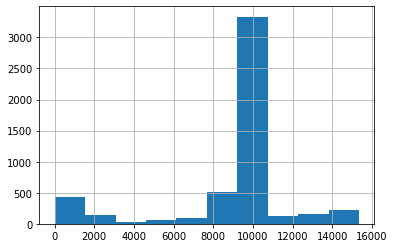

In [17]:
X_train_raw.isna().sum(axis='columns').hist()

<AxesSubplot:>

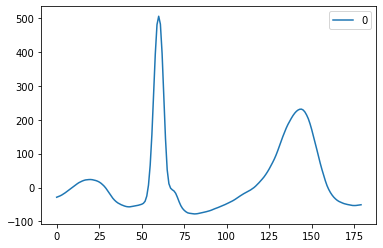

In [18]:
pd.DataFrame(np.mean(series_to_heartbeats(X_train_raw.iloc[0])[0], axis=0)).plot()

In [19]:
extract_features(X_train_raw.loc[120]).head()

0    1168.810041
1      49.019200
2    1072.369701
3    1140.929843
4    1162.024837
dtype: float64

#### Extract features

In [20]:
X_train = X_train_raw.progress_apply(extract_features, axis=1)

  0%|          | 0/5117 [00:00<?, ?it/s]

In [21]:
X_test = X_test_raw.progress_apply(extract_features, axis=1)

  0%|          | 0/3411 [00:00<?, ?it/s]

In [22]:
print(f"X_train has {X_train.isna().sum().sum()} null values.")
print(f"X_test has {X_test.isna().sum().sum()} null values.")

X_train has 0 null values.
X_test has 0 null values.


In [99]:
utils.features_list()[:5]

['rpeaks_amplitude-mean',
 'rpeaks_amplitude-std',
 'rpeaks_amplitude-min',
 'rpeaks_amplitude-quantile-25',
 'rpeaks_amplitude-quantile-50']

In [101]:
visualize(X_train, y_train_raw, 'rpeaks_amplitude-mean', 'rpeaks_amplitude-quantile-50')

#### Standardize dataset

In [ ]:
X_train, X_test = standardize_data(X_train, X_test)

In [ ]:
gs_svc = svc(X_train, np.array(y_train_raw).ravel())

In [ ]:
gs_random_forest = random_forest(X_train, np.array(y_train_raw).ravel())

In [ ]:
gs_gbc = gbc(X_train, np.array(y_train_raw).ravel())

In [ ]:
gs_ensemble = ensemble([
    SVC(probability=True, **gs_svc.best_params_), 
    RandomForestClassifier(**gs_random_forest.best_params_),
    GradientBoostingClassifier(**gs_gbc.best_params_)
], X_train, np.array(y_train_raw).ravel())

---
## Generate new submission

In [ ]:
model = gs_ensemble
sub_id = 11
prediction = pd.DataFrame(model.predict(X_test))

In [ ]:
#create_submission(sub_id, prediction)

**Solutions must be submitted on the [project website](https://aml.ise.inf.ethz.ch/task2/).**